In [1]:
import matplotlib.pyplot as plt

import pylab as pl 

import numpy as np 

image =pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO_cyclegan_predictions.npz') 


In [2]:

def trim_edges ( length , delta, Lx,Nx  ) :
    Ly =Lx
    Ny =Nx
    mask = np.ones(Nx*Ny)
    xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
    yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny
    mask[np.where(xarr.flatten() < Lx / length)] = 0
    mask[np.where(xarr.flatten() > (delta) * Lx / length)] = 0
    mask[np.where(yarr.flatten() < Ly / length )] = 0
    mask[np.where(yarr.flatten() > delta  * Ly / length)] = 0
    mask = mask.reshape([Ny, Nx])
    return mask

def standardize(x ):
    xresc =  (x - x.mean())/x.std() 
    return xresc


def make_hog_image(image): 
    fd, hog_image = hog(image, orientations=4, pixels_per_cell=(4, 4),
                        cells_per_block=(1, 1), visualize=True, multichannel=False)
    #hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return hog_image#_rescaled 

def augment_dataset (arr ) : 
    # augment training   set by flipping the axis
    flipped1 =np.array([  np.flip( p, axis=1)  for p in arr ] )

    flipped0 =np.array([  np.flip( p, axis=0)  for p in arr ] ) 
    return ( np.concatenate((arr,  flipped0,  flipped1  ) ,axis=0 ) )


def minmaxrescale(x, a=0, b=1):
    """
    Performs  a MinMax Rescaling on an array `x` to a generic range :math:`[a,b]`.
    """
    xresc = (b - a) * (x - x.min()) / (x.max() - x.min()) + a
    return xresc
 

def split_without_overlap(xraw, longitudemask ):  
    training = longitudemask [0] 
    validation = longitudemask [1] 
    test = longitudemask [2] 
    return xraw[training], xraw[validation], xraw[test ] 

def preprocess_data(  arr,  split_wo_overlap=False, longitudemask =None , rescale = True  ):  
    if rescale :
        if arr.shape[-1]>1: 
            for i in range(arr.shape[0]): 
                for k in range(arr.shape[-1]) : 
                    arr[i,:,:,k]=minmaxrescale(arr[i,:,:,k], a=-1,b=1 ) 
        else:
            for i in range(arr.shape[0]): 
                arr[i ]=minmaxrescale(arr[i ], a=-1,b=1 ) 
    if  split_wo_overlap and longitudemask is not None  :
        xtrain, xval,xtest =split_without_overlap  (arr , longitudemask  ) 
    elif  split_wo_overlap and longitudemask is   None  :
        raise ValueError (f'longitudemask is set to {longitudemask}, must be an array to split the data ')
    else :
        xtrain, xval,xtest =split_trainvaltest_sets(arr  )
    
    return xtrain, xval,xtest  


In [16]:
dustset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/COM_CompMap_Dust-GNILC-F857_2048_R2.00_15amin_training.npz')['patches']
hiset = pl.log10(pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/NHI_HI4Pi_16amin_nside2048_inpainted_training.npz')['patches']) 
longimask = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO//co_ext_longitudinal_splitmask.npy')
dtrset,_,dtset = preprocess_data(dustset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
#dtset =augment_dataset(dtset)
htrset,_,htset = preprocess_data(hiset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
#htset =augment_dataset(htset)
coset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO10type2_15amin_nside2048_training.npz')['patches']

cotrset,_,cotset = preprocess_data(coset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
#cotset =augment_dataset(cotset)
image_test =pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO_cyclegan_predictions.npz') 
copt = image_test['ypred'] [:,:,:,0 ]
#image_train =pl.load('CO10net_train_predictions.npz') 
#coptr = image_train['ypred'] [:,:,:,0 ]
Ntest= dtset.shape[0]

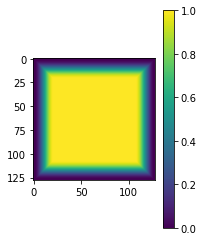

In [17]:
import numpy as np 
import pymaster as nmt
#image =pl.load('../heavy_maps/Forse_CO_AME/AME_23GHz_80amin_nside2048_training.npz')['patches'][0];pixelsize=3.75; Nx=320 ;length = 256; aposize=.5; reso_arcmin=80; deltaell=25
#image =pl.load('../heavy_maps/Forse_CO_AME/CO10type2_15amin_nside2048_training.npz')['patches'][0];
pixelsize=1.5 ; Nx = 128; length=64; aposize=.5; reso_arcmin=15; deltaell=200

#

Lx = np.radians( pixelsize *Nx /60. ) 

lmin = 5* np.pi/Lx 
lmax= np.pi/np.radians(reso_arcmin/3/60 )
delta= length -1
mask = trim_edges(  length, delta, Lx,Nx  )
apomask = nmt.mask_apodization_flat(mask   , Lx, Lx ,aposize=aposize, apotype="C2")
pl.subplot(121) 
pl.imshow(  apomask );pl.colorbar() 
 

In [18]:
Nb = np.int_ ((lmax-lmin)/deltaell)
lrange = np.linspace( (lmin)  , (lmax) ,Nb  ) 

l0_bins =lrange[0:-1]
lf_bins =lrange[ 1:]
b = nmt.NmtBinFlat(l0_bins, lf_bins)
ells_uncoupled = b.get_effective_ells()


In [19]:
 
#w00.read_from("w00_flat_CO.fits")

In [20]:
coset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO10type2_15amin_nside2048_training.npz')['patches']

cotrset,_,cotset = preprocess_data(coset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
copt = image_test['ypred'] [:,:,:,0 ]
auto_spectra ={'Dust': [], 'CO J:1-0 real': [], 
                'CO J:1-0 mock': [],
                'HI': [],    } 


for i in range(Ntest): 
    """
    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(dtset[i], a = -1 , b=1 )])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(htset[i], a = -1 , b=1 ) ])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(cotset [i ], a = -1 , b=1 )])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ copt [i ]] ) 
    """ 

    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [  standardize  (dtset[i])])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (htset[i]) ])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (cotset [i ] )])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (copt [i ]  )  ] ) 
   
    nhi00_c =  nmt.compute_coupled_cell_flat(fnhi, fnhi, b)
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)
    cot00_c =  nmt.compute_coupled_cell_flat(fcot, fcot, b)
    cop00_c =  nmt.compute_coupled_cell_flat(fcop, fcop, b)
    copt00_c =  nmt.compute_coupled_cell_flat(fcot, fcop, b)
    w00 = nmt.NmtWorkspaceFlat()  

    try: 
        dust00  = w00.decouple_cell(dust00_c)

    except AttributeError: 
        w00.compute_coupling_matrix(fd, fd, b)
        dust00  = w00.decouple_cell(dust00_c)
    nhi00  = w00.decouple_cell(nhi00_c)
    cot00  = w00.decouple_cell(cot00_c)
    cop00  = w00.decouple_cell(cop00_c)
    copt00  = w00.decouple_cell(copt00_c)
    
    auto_spectra  ['Dust'] .append(   dust00[0])   
    auto_spectra  ['CO J:1-0 real'] .append(  cot00[0] )   
    auto_spectra  ['HI'] .append(   nhi00[0])  
    auto_spectra  ['CO J:1-0 mock'] .append( cop00[0] )    
    #auto_spectra  ['CO_real X CO_mock'] .append(   copt00[0]   ) 



/tmp/ipykernel_822655/4141000347.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  pl.plot(ells_uncoupled, np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,linestyle,color=f'k', linestyle='--',   lw=2)
/tmp/ipykernel_822655/4141000347.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  pl.plot(ells_uncoupled, np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,linestyle,color=f'k',linestyle='--',    lw=2)


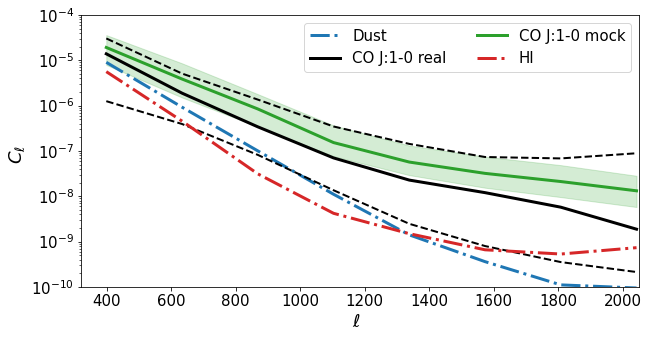

In [21]:
pl.figure(figsize=(10,5)) 
for ii, k in enumerate(auto_spectra.keys() ):
    
    if k=='HI' or k=='Dust' :
        linestyle='-.'
        pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) , linestyle,color=f'C{ii}',label=k, lw=3)
        
    else:
        linestyle='-' 
        if k[-1]=='k':
            pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) ,linestyle,color=f'C{ii}', label=k, lw=3)
            
            pl.fill_between ( ells_uncoupled,   np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,
                             np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,alpha=.2,  color=f'C{ii}')
        else: 
            pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) ,linestyle,color=f'k', label=k, lw=3)
            pl.plot(ells_uncoupled, np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,linestyle,color=f'k', linestyle='--',   lw=2)
            pl.plot(ells_uncoupled, np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,linestyle,color=f'k',linestyle='--',    lw=2)
            

    
pl.semilogy()
pl.legend(ncol=2,loc='upper right' , fontsize=15) 
pl.xlim(320,2050)
pl.ylim( 1e-10,1e-4)
pl.ylabel(r'$C_{\ell} $  ', fontsize=18)
pl.xlabel(r'$ {\ell} $  ', fontsize=18)
pl.xticks(fontsize=15) 
pl.yticks(fontsize=15) 

 
pl.savefig('spectra10.pdf') 

(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

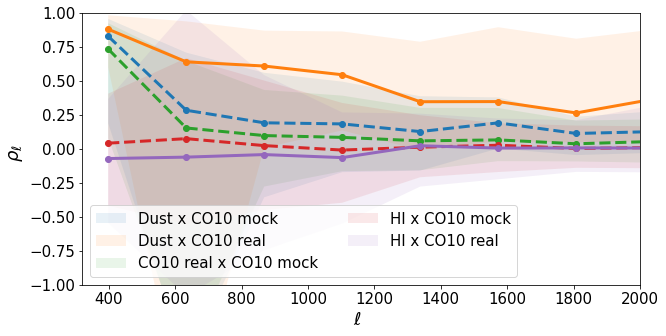

In [22]:
pl.figure(figsize=(10,5)) 


cross_spectra ={'Dust x CO10 mock': [], 'Dust x CO10 real': [], 
                'CO10 real x CO10 mock': [],# 'CO_real X CO_real': [], 
                'HI x CO10 mock': [], 'HI x CO10 real': []  } 


for i in range(Ntest): 
    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(dtset[i], a = -1 , b=1 )])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(htset[i], a = -1 , b=1 ) ])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(cotset [i ], a = -1 , b=1 )])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ copt [i ]] ) 
    """
    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [  standardize (dtset[i])])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize  (htset[i])])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize  (cotset[i])])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (minmaxrescale(copt [i ]  , a = cotset[i].min(), b=cotset[i].max() )) ] ) 
                                              #, a = cotset[i].min(), b=cotset[i].max() )])
    
    """ 
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)


    dust00  = w00.decouple_cell(dust00_c)
    nhi00_c =  nmt.compute_coupled_cell_flat(fnhi, fnhi, b)
    nhi00  = w00.decouple_cell(nhi00_c)
    cot00_c =  nmt.compute_coupled_cell_flat(fcot, fcot, b)
    cot00  = w00.decouple_cell(cot00_c)
    cop00_c =  nmt.compute_coupled_cell_flat(fcop, fcop, b)
    cop00  = w00.decouple_cell(cop00_c)
    
    dustcot00_c =  nmt.compute_coupled_cell_flat(fd, fcot, b)
    dustcot00  = w00.decouple_cell(dustcot00_c)
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)
    dust00  = w00.decouple_cell(dust00_c)
    dustcop00_c =  nmt.compute_coupled_cell_flat(fd, fcop, b)
    dustcop00  = w00.decouple_cell(dustcop00_c)

    copt00_c =  nmt.compute_coupled_cell_flat(fcot, fcop, b)
    copt00  = w00.decouple_cell(copt00_c)
    nhicop00_c =  nmt.compute_coupled_cell_flat(fnhi, fcop, b)
    nhicop00  = w00.decouple_cell(nhicop00_c)
    nhicot00_c =  nmt.compute_coupled_cell_flat( fnhi,fcot, b)
    nhicot00  = w00.decouple_cell(nhicot00_c)
    
    cross_spectra  ['Dust x CO10 mock'] .append(  dustcop00[0]/np.sqrt(abs(cop00[0] *dust00[0])  ) ) 
    cross_spectra  ['Dust x CO10 real'] .append(  dustcot00[0]/np.sqrt(abs(cot00[0] *dust00[0])   ) ) 
    cross_spectra  ['HI x CO10 mock'] .append(  nhicop00[0] /np.sqrt(abs(cop00[0] *nhi00[0])  )) 
    cross_spectra  ['HI x CO10 real'] .append(  nhicot00[0] /np.sqrt(abs(cot00[0] *nhi00[0] )  ))    
    cross_spectra  ['CO10 real x CO10 mock'] .append(   copt00[0]/np.sqrt(abs(cot00[0] *cop00[0])    ) ) 
for k in cross_spectra.keys() :
    #if k[:2]=='HI':continue 
    if(k[-3])=='o':
        
        linestyle='o--'
    else:
        linestyle='o-'
    linewidth=3
    pl.fill_between ( ells_uncoupled, np.quantile(q=0.05,a=cross_spectra[k],axis=0) ,
                         np.quantile(q=0.95 ,a=cross_spectra[k],axis=0),alpha=.1, label=k)
    pl.plot(ells_uncoupled, np.median(cross_spectra[k],axis=0) ,linestyle, lw=linewidth )
    
#pl.plot()
pl.legend(ncol=2,loc='lower left' , fontsize=15) 
pl.xlim(320,2000)
pl.ylim( -1,1.)
pl.ylabel(r'$ \rho _{\ell} $  ', fontsize=18)
pl.xlabel(r'$ {\ell} $  ', fontsize=18)
pl.xticks(fontsize=15) 
pl.yticks(fontsize=15) 

In [23]:
coset = pl.load('/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/CO21type2_15amin_nside2048_training.npz')['patches']

cotrset,_,cotset = preprocess_data(coset,split_wo_overlap=True, longitudemask=longimask , rescale=False )
copt = image_test['ypred'] [:,:,:,1 ]
auto_spectra ={'Dust': [], 'CO J:2-1 real': [], 
                'CO J:2-1 mock': [],
                'HI': [],    } 



for i in range(Ntest): 
    """
    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(dtset[i], a = -1 , b=1 )])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(htset[i], a = -1 , b=1 ) ])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(cotset [i ], a = -1 , b=1 )])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ copt [i ]] ) 
    """ 

    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [  standardize (dtset[i])])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [standardize  (htset[i]) ])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (cotset [i ] )])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ standardize (copt [i ]  )  ] ) 
    nhi00_c =  nmt.compute_coupled_cell_flat(fnhi, fnhi, b)
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)
    cot00_c =  nmt.compute_coupled_cell_flat(fcot, fcot, b)
    cop00_c =  nmt.compute_coupled_cell_flat(fcop, fcop, b)
    copt00_c =  nmt.compute_coupled_cell_flat(fcot, fcop, b)
    w00 = nmt.NmtWorkspaceFlat()  

    try: 
        dust00  = w00.decouple_cell(dust00_c)

    except AttributeError: 
        w00.compute_coupling_matrix(fd, fd, b)
        dust00  = w00.decouple_cell(dust00_c)
    nhi00  = w00.decouple_cell(nhi00_c)
    cot00  = w00.decouple_cell(cot00_c)
    cop00  = w00.decouple_cell(cop00_c)
    copt00  = w00.decouple_cell(copt00_c)
    
    auto_spectra  ['Dust'] .append(   dust00[0])   
    auto_spectra  ['CO J:2-1 real'] .append(  cot00[0] )   
    auto_spectra  ['HI'] .append(   nhi00[0])  
    auto_spectra  ['CO J:2-1 mock'] .append( cop00[0] )    
    #auto_spectra  ['CO_real X CO_mock'] .append(   copt00[0]   ) 


/tmp/ipykernel_822655/1058816253.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  pl.plot(ells_uncoupled, np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,linestyle,color=f'k', linestyle='--',   lw=2)
/tmp/ipykernel_822655/1058816253.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  pl.plot(ells_uncoupled, np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,linestyle,color=f'k',linestyle='--',    lw=2)


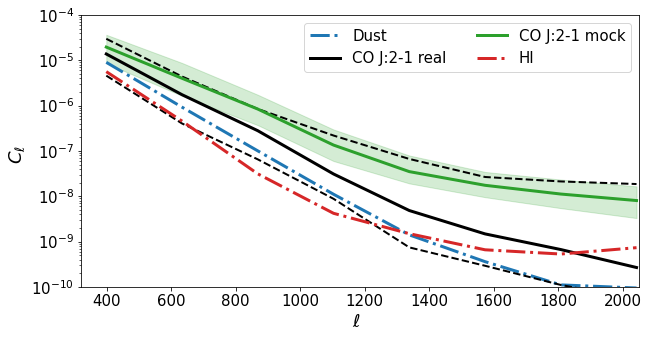

In [26]:
pl.figure(figsize=(10,5)) 
for ii, k in enumerate(auto_spectra.keys() ):
    
    if k=='HI' or k=='Dust' :
        linestyle='-.'
        pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) , linestyle,color=f'C{ii}',label=k, lw=3)
        
    else:
        linestyle='-' 
        if k[-1]=='k':
            pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) ,linestyle,color=f'C{ii}', label=k, lw=3)
            
            pl.fill_between ( ells_uncoupled,   np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,
                             np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,alpha=.2,  color=f'C{ii}')
        else: 
            pl.plot(ells_uncoupled, np.median(auto_spectra[k], axis=0) ,linestyle,color=f'k', label=k, lw=3)
            pl.plot(ells_uncoupled, np.quantile(q=0.025,a=auto_spectra[k],axis=0) ,linestyle,color=f'k', linestyle='--',   lw=2)
            pl.plot(ells_uncoupled, np.quantile(q=0.975 ,a=auto_spectra[k],axis=0) ,linestyle,color=f'k',linestyle='--',    lw=2)
            

    
pl.semilogy()
pl.legend(ncol=2,loc='upper right' , fontsize=15) 
pl.xlim(320,2050)
pl.ylim( 1e-10,1e-4)
pl.ylabel(r'$C_{\ell} $  ', fontsize=18)
pl.xlabel(r'$ {\ell} $  ', fontsize=18)
pl.xticks(fontsize=15) 
pl.yticks(fontsize=15) 





pl.savefig('spectra21.pdf') 


(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

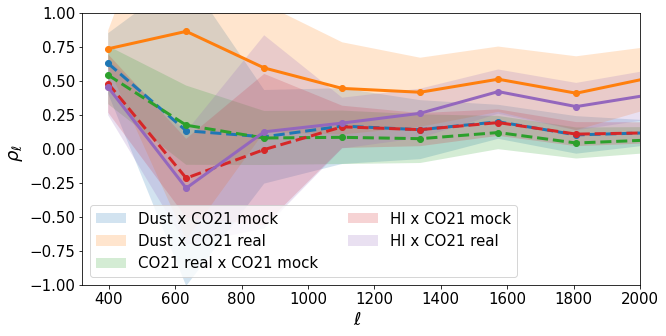

In [25]:
pl.figure(figsize=(10,5)) 


cross_spectra ={'Dust x CO21 mock': [], 'Dust x CO21 real': [], 
                'CO21 real x CO21 mock': [],# 'CO_real X CO_real': [], 
                'HI x CO21 mock': [], 'HI x CO21 real': []  } 


for i in range(Ntest): 
    
    fd = nmt.NmtFieldFlat(Lx, Lx, apomask, [ (dtset[i])])
    fnhi = nmt.NmtFieldFlat(Lx, Lx, apomask, [ (htset[i])])
    fcot=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ (cotset[i])])
    fcop=  nmt.NmtFieldFlat(Lx, Lx, apomask, [ minmaxrescale(copt [i ], a = cotset[i].min(), b=cotset[i].max() )])
    
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)
    dust00  = w00.decouple_cell(dust00_c)
    nhi00_c =  nmt.compute_coupled_cell_flat(fnhi, fnhi, b)
    nhi00  = w00.decouple_cell(nhi00_c)
    cot00_c =  nmt.compute_coupled_cell_flat(fcot, fcot, b)
    cot00  = w00.decouple_cell(cot00_c)
    cop00_c =  nmt.compute_coupled_cell_flat(fcop, fcop, b)
    cop00  = w00.decouple_cell(cop00_c)
    
    dustcot00_c =  nmt.compute_coupled_cell_flat(fd, fcot, b)
    dustcot00  = w00.decouple_cell(dustcot00_c)
    dust00_c =  nmt.compute_coupled_cell_flat(fd, fd, b)
    dust00  = w00.decouple_cell(dust00_c)
    dustcop00_c =  nmt.compute_coupled_cell_flat(fd, fcop, b)
    dustcop00  = w00.decouple_cell(dustcop00_c)

    copt00_c =  nmt.compute_coupled_cell_flat(fcot, fcop, b)
    copt00  = w00.decouple_cell(copt00_c)
    nhicop00_c =  nmt.compute_coupled_cell_flat(fnhi, fcop, b)
    nhicop00  = w00.decouple_cell(nhicop00_c)
    nhicot00_c =  nmt.compute_coupled_cell_flat( fnhi,fcot, b)
    nhicot00  = w00.decouple_cell(nhicot00_c)
    
    cross_spectra  ['Dust x CO21 mock'] .append(  dustcop00[0]/np.sqrt(abs(cop00[0] *dust00[0])  ) ) 
    cross_spectra  ['Dust x CO21 real'] .append(  dustcot00[0]/np.sqrt(abs(cot00[0] *dust00[0])   ) ) 
    cross_spectra  ['HI x CO21 mock'] .append(  nhicop00[0] /np.sqrt(abs(cop00[0] *nhi00[0])  )) 
    cross_spectra  ['HI x CO21 real'] .append(  nhicot00[0] /np.sqrt(abs(cot00[0] *nhi00[0] )  ))    
    cross_spectra  ['CO21 real x CO21 mock'] .append(   copt00[0]/np.sqrt(abs(cot00[0] *cop00[0])    ) ) 
for k in cross_spectra.keys() :
    #if k[:2]=='HI':continue 
    if(k[-3])=='o':
        
        linestyle='o--'
    else:
        linestyle='o-'
    linewidth=3
    pl.fill_between ( ells_uncoupled, np.array(cross_spectra[k]).mean(axis=0)  - np.array(cross_spectra[k]).std(axis=0), 
             np.array(cross_spectra[k]).mean(axis=0) +  np.array(cross_spectra[k]).std(axis=0),alpha=.2, label=k)
    pl.plot(ells_uncoupled, np.array(cross_spectra[k]).mean(axis=0) ,linestyle, lw=linewidth )
    
#pl.plot()
pl.legend(ncol=2,loc='lower left' , fontsize=15) 
pl.xlim(320,2000)
pl.ylim( -1,1.)
pl.ylabel(r'$ \rho _{\ell} $  ', fontsize=18)
pl.xlabel(r'$ {\ell} $  ', fontsize=18)
pl.xticks(fontsize=15) 
pl.yticks(fontsize=15) 